In [1]:
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
import os
import re
import warnings
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

In [2]:
all_files = glob.glob("telematics_data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
#     df['VehicleId'] = int(re.findall(r'\d+',filename)[0])
    df.insert(0,'VehicleId',int(re.findall(r'\d+',filename)[0]))
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.insert(2,'datetime',pd.to_datetime(frame['timestamp'],unit='s'))
frame.sort_values(by=['VehicleId','datetime'],axis=0,inplace=True)
frame

VehicleId   timestamp            datetime  longitude   latitude  \
5996           1  1637190160 2021-11-17 23:02:40  12.487590  55.607189   
5997           1  1637190160 2021-11-17 23:02:40  12.487590  55.607189   
5998           1  1637190160 2021-11-17 23:02:40  12.487590  55.607189   
5999           1  1637190160 2021-11-17 23:02:40  12.487590  55.607189   
6000           1  1637190160 2021-11-17 23:02:40  12.487590  55.607189   
...          ...         ...                 ...        ...        ...   
11987         10  1633092646 2021-10-01 12:50:46   9.999500  53.392792   
11988         10  1633092646 2021-10-01 12:50:46   9.999500  53.392792   
11989         10  1633092890 2021-10-01 12:54:50   9.948216  53.429264   
11990         10  1633092915 2021-10-01 12:55:15   9.941238  53.430801   
11991         10  1633092950 2021-10-01 12:55:50   9.931626  53.433842   

       mileage      speed  fuelLevel  isMoving  elevation road_type  \
5996       NaN   9.854212        NaN     False         -1       NaN   
5997       NaN   9.854212        NaN     False         -1       NaN   
5998       NaN   9.854212        NaN     False         -1       NaN   
5999       NaN   9.854212        NaN     False         -1       NaN   
6000       NaN   9.854212        NaN     False         -1       NaN   
...        ...        ...        ...       ...        ...       ...   
11987      NaN  83.610674       80.4     False         17  motorway   
11988      NaN  83.610674       80.4     False         17  motorway   
11989      NaN  69.472194       80.0     False         82       NaN   
11990      NaN  73.105931       80.0     False         68       NaN   
11991      NaN  74.745733       80.0     False         77       NaN   

      surface_type   temp  open_weatherapi_id  humidity  wind_speed  wind_deg  
5996           NaN  -0.26                 800        89        3.09       320  
5997           NaN  -0.26                 800        89        3.09       320  
5998           NaN  -0.01                 800        89        3.09       320  
5999           NaN  -0.01                 800        89        3.09       320  
6000           NaN  -0.01                 800        89        3.09       320  
...            ...    ...                 ...       ...         ...       ...  
11987      asphalt  17.42                 800        59        6.69       200  
11988      asphalt  17.42                 800        59        6.69       200  
11989          NaN  17.19                 800        58        6.69       200  
11990          NaN  17.18                 800        58        6.69       200  
11991          NaN  17.00                 800        58        6.69       200  

[14990 rows x 17 columns]

## Question 1 : Count Trips By Week

In [3]:
def calculate_distance(coords_1,lat2,lon2):
    coords_2 = (lat2,lon2)
    return int(geopy.distance.geodesic(coords_1, coords_2).miles)

In [4]:
def CountTripsByWeek(VehicalId):
    df=frame[frame['VehicleId']==VehicalId]
    df.reset_index(inplace=True)
    
    coords_1 = (df['latitude'][0],df['longitude'][0])
    
    df['distance'] = df.apply(lambda x: calculate_distance(coords_1,x['latitude'],x['longitude']), axis=1)
    df['chg'] = np.where(((df['distance'].astype(int) == 0 )& (df['distance'].shift(-1).replace(np.nan,0).astype(int) > 0 )), 1, 0)
    
    try:
        df['chg'].iat[df[df['chg']==1].index[0]]=0
    except:
        pass
    TripByWeek=df.resample('W', on='datetime')['chg'].sum()
    TripByWeek.plot.bar()
    print(TripByWeek)
   

Enter Vehical Id Between 1 to 10:8
datetime
2021-10-03    5
2021-10-10    2
Freq: W-SUN, Name: chg, dtype: int64


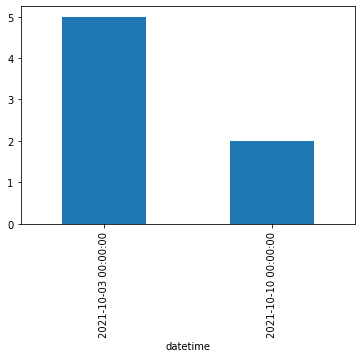

In [5]:
VehicalId = int(input("Enter Vehical Id Between 1 to 10:"))
CountTripsByWeek(VehicalId)

## Question 2: Find out the dates where refuelling were made.

In [6]:
def RefuelOnDate(VehicalId):
    df=frame[frame['VehicleId']==VehicalId]
    df.reset_index(inplace=True)
    fuelindex = np.where((df['fuelLevel'].diff(1))>=10, 1, 0)    
    counter = 0
    indexList=[]
    for i in np.where(fuelindex==1)[0]:
        indexList.append(i)
        print(f"DateTime = {df.iloc[i]['datetime']}, Fuel Level From {df.iloc[i-1]['fuelLevel']} To {df.iloc[i]['fuelLevel']}")
    
    df2 = df[['datetime','fuelLevel']].set_index('datetime')
    df2.plot(linestyle='-',markevery=indexList,color='b' ,marker='*',ms=15, markerfacecolor='r',figsize=(10,10))

Enter Vehical Id Between 1 to 10:2
DateTime = 2021-09-30 09:36:29, Fuel Level From 20.4 To 100.0
DateTime = 2021-10-05 11:28:26, Fuel Level From 10.8 To 100.0


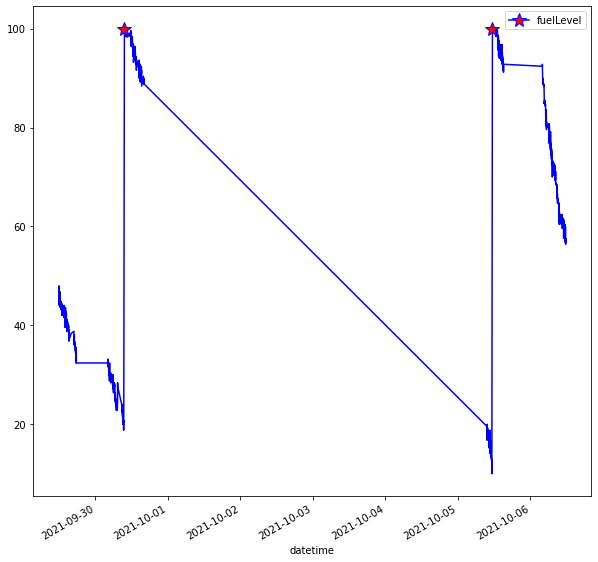

In [7]:
VehicalId = int(input("Enter Vehical Id Between 1 to 10:"))
RefuelOnDate(VehicalId)

## Question 3:Preprocess the dataset to remove outliers and smoothen the fuelLevel datapoint. Demonstrate atleast 3 methods.

### 1) Detecting outliers using Boxplot

Enter Vehical Id Between 1 to 10:4
Max: 82.8 Min: 28.8


<AxesSubplot:xlabel='fuelLevel'>

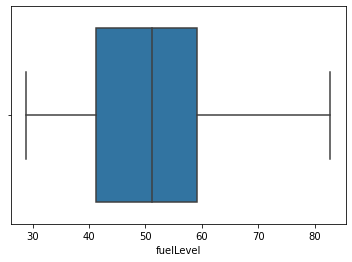

In [8]:
VehicalId = int(input("Enter Vehical Id Between 1 to 10:"))
df=frame[frame['VehicleId']==VehicalId]
df.reset_index(inplace=True)
df['fuelLevel']=df['fuelLevel'].fillna(0)
print("Max:",max(df['fuelLevel']),"Min:",min(df['fuelLevel']))
sns.boxplot(df['fuelLevel'])

#### Note: In All vehical dataset fuelLevel range is fixed which is 0 to 100. so if fuelLevel value is not bettwen this range than that value is outlier.

### 2) Moving Average on fuelLevel 

#### Smoothing data using Moving Average

<AxesSubplot:>

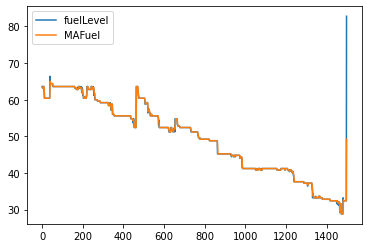

In [9]:
df['MAFuel']=df['fuelLevel'].rolling(3).mean()
df[['fuelLevel','MAFuel']].plot()

### 3) Z-score treatment

In [10]:
#Finding the Boundary Values
upper_limit = df['fuelLevel'].mean() + 0.5*df['fuelLevel'].std()
print("Highest allowed",upper_limit)
lower_limit = df['fuelLevel'].mean() - 0.5*df['fuelLevel'].std()
print("Lowest allowed",lower_limit)

Highest allowed 54.43845575817612
Lowest allowed 44.29349887824743


#### Smoothing fuel data by Capping using Z-score

In [11]:
df['fuelLevel'] = np.where(
    df['fuelLevel']>upper_limit,
    upper_limit,
    np.where(
        df['fuelLevel']<lower_limit,
        lower_limit,
        df['fuelLevel']
    )
)
df['fuelLevel'].describe()

count    1499.000000
mean       49.549120
std         4.609155
min        44.293499
25%        44.293499
50%        51.200000
75%        54.438456
max        54.438456
Name: fuelLevel, dtype: float64

## Question 4: Deduce driving behaviour: High/Low Acceleration and Braking.

In [12]:
def DrivingBehaviour(VehicalId):
    df=frame[frame['VehicleId']==VehicalId]
    df.reset_index(inplace=True)
    df["timeelapsed"]=(df.datetime - df.datetime.shift(1)).dt.total_seconds().fillna(0.00)
    df['acceleration'] = ((df['speed'] - df['speed'].shift(1)) / df["timeelapsed"]).fillna(0.00)
    # df['acceleration'].plot()
    df['event']="Normal"
    df['event']=np.where(df['acceleration'] < -2.00,'High Braking',df['event'])
    df['event']=np.where(((df['acceleration'] > 1.00) & (df['acceleration'] < 2.00)),'Low Acceleration',df['event'])
    df['event']=np.where(df['acceleration'] > 2.00,'High Acceleration',df['event'])
    # sns.countplot(x="event", data=df)
    try:
        df['event'][~(df['event']=='Normal')].value_counts().plot(kind='barh',color='b')
        print(df['event'][~(df['event']=='Normal')].value_counts())
    except:
        print("Vehical is not moved..")

Enter Vehical Id Between 1 to 10:2
High Braking         13
Low Acceleration      7
High Acceleration     1
Name: event, dtype: int64


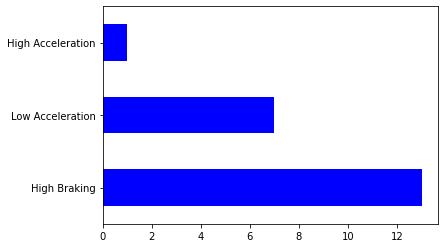

In [13]:
VehicalId = int(input("Enter Vehical Id Between 1 to 10:"))
DrivingBehaviour(VehicalId)

## Question 5: Find out three principal components on all the data combined. 

In [14]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# label_encoder object.
label_encoder = preprocessing.LabelEncoder()
filterframe = frame 
# Encode labels in column 'road_type' and 'surface_type'.
filterframe['road_type']= label_encoder.fit_transform(filterframe['road_type'])
filterframe['surface_type']= label_encoder.fit_transform(filterframe['surface_type'])

In [15]:
#drop Duplicates
filterframe.drop_duplicates(inplace=True)

dataframe = filterframe[['speed', 'fuelLevel', 'elevation', 'road_type',
       'surface_type', 'temp','open_weatherapi_id', 'humidity', 'wind_speed',
       'wind_deg']]

dataframe.dropna(inplace=True)

x = dataframe.loc[:,['speed', 'fuelLevel', 'elevation', 'road_type',
       'surface_type', 'temp','open_weatherapi_id', 'humidity', 'wind_speed',
       'wind_deg']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [16]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
com=pca.components_
principalDf = pd.DataFrame(data = principalComponents
             , columns = dataframe.columns[[com[0].argmax(),com[1].argmax(),com[2].argmax()]])
print(f"Three principal components on all the data are :{dataframe.columns[com[0].argmax()]},{dataframe.columns[com[1].argmax()]} and {dataframe.columns[com[2].argmax()]}")
principalDf.head()

Three principal components on all the data are :elevation,road_type and humidity


elevation  road_type  humidity
0  -1.170050   0.873478 -1.432474
1  -0.929673   0.558592 -1.048070
2  -0.996504   0.686327 -1.199042
3  -0.930359   0.550612 -1.029814
4  -1.247307   1.039877 -1.638307

## Question 6: Optional: Demonstrate any hypothesis of your liking using unsupervised learning technique (For eg., cluster the vehicles based on some set of features).

In [17]:
tempframe=frame.drop(['isMoving','mileage'],axis=1)
tempframe['fuelLevel'].fillna(0,inplace=True)
tempframe=tempframe[tempframe['fuelLevel']!= 0]
tempframe.drop_duplicates(inplace=True)

In [18]:
dataset = tempframe[['speed','wind_speed','humidity']]
x = dataset.values
x

array([[16.84839194,  5.14      , 80.        ],
       [54.78710651,  5.14      , 80.        ],
       [42.07671571,  5.14      , 80.        ],
       ...,
       [69.47219391,  6.69      , 58.        ],
       [73.10593109,  6.69      , 58.        ],
       [74.74573269,  6.69      , 58.        ]])

In [19]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
normalized_X = sc_X.fit_transform(x)
normalized_X

array([[-1.5821655 ,  0.03579214,  0.21148389],
       [-0.25981059,  0.03579214,  0.21148389],
       [-0.7028316 ,  0.03579214,  0.21148389],
       ...,
       [ 0.25203853,  0.55746334, -1.20580929],
       [ 0.37869253,  0.55746334, -1.20580929],
       [ 0.43584786,  0.55746334, -1.20580929]])

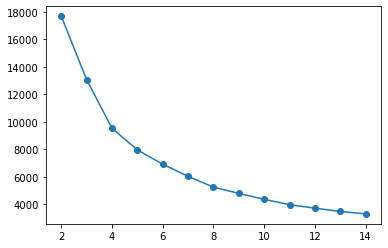

In [20]:
#find the optimal number for n_cluster using elbow method
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]
for c in clusters_range:
    kmeans = KMeans (init='k-means++',n_clusters=c,n_init=100, random_state=0).fit(normalized_X)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

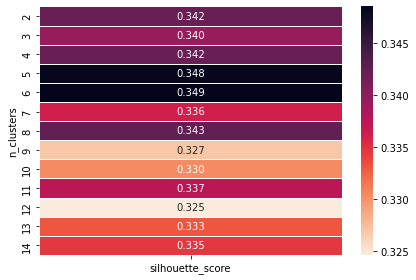

In [21]:
from sklearn.metrics import silhouette_samples,silhouette_score
clusters_range = range (2,15)
results =[]
for c in clusters_range:
    clusterer = KMeans(init='k-means++',n_clusters=c,n_init=100, random_state=0)
    cluster_labels = clusterer.fit_predict(normalized_X)
    silhouette_avg= silhouette_score(normalized_X, cluster_labels)
    results.append ([c,silhouette_avg])
result = pd.DataFrame(results, columns=["n_clusters","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters",values="silhouette_score")

plt.figure()
sns.heatmap (pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

In [22]:
# finding the clusters based on input matrix "x"
model = KMeans(n_clusters = 5, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(x)

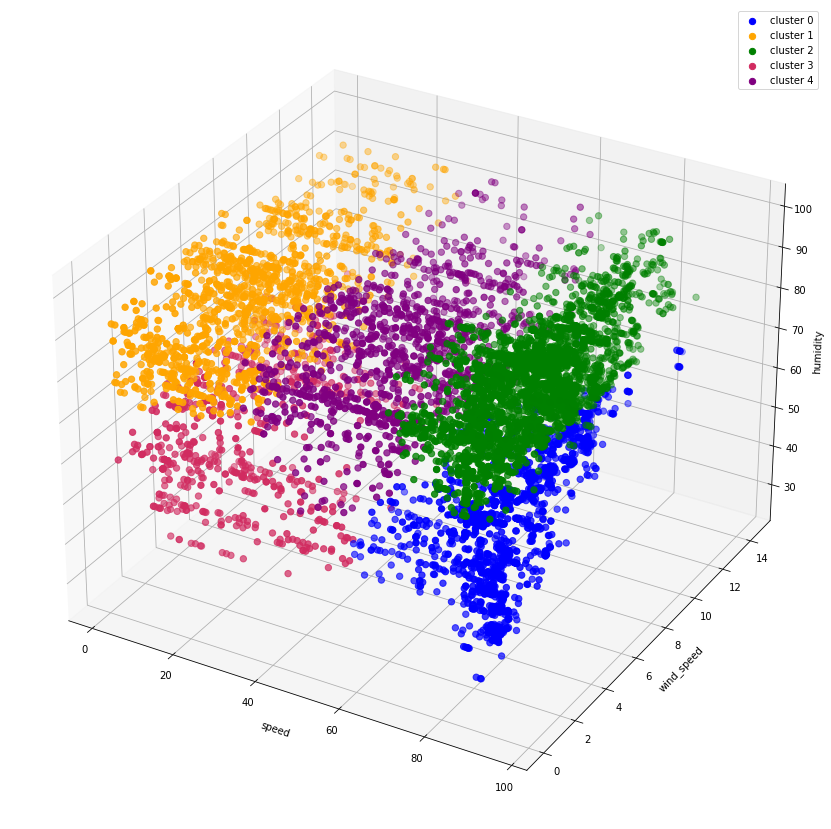

In [23]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],x[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
ax.set_xlabel('speed')
ax.set_ylabel('wind_speed')
ax.set_zlabel('humidity')
ax.legend()
plt.show()


## Some Hypothesis from the scatter Plot are:

### 1) speed is high,when humidity is below 60
### 2) speed is low,when humidity is above 70 and average wind above then 4

## Question 7: Optional: Visualise the data for the trips per vehicle using Leaflet and Folium.

In [24]:
import folium
from branca.element import Figure

coords_1=frame[frame['VehicleId']==1][['latitude','longitude']].values.tolist()
coords_2=frame[frame['VehicleId']==2][['latitude','longitude']].values.tolist()
coords_3=frame[frame['VehicleId']==3][['latitude','longitude']].values.tolist()
coords_4=frame[frame['VehicleId']==4][['latitude','longitude']].values.tolist()
coords_5=frame[frame['VehicleId']==5][['latitude','longitude']].values.tolist()
coords_6=frame[frame['VehicleId']==6][['latitude','longitude']].values.tolist()
coords_7=frame[frame['VehicleId']==7][['latitude','longitude']].values.tolist()
coords_8=frame[frame['VehicleId']==8][['latitude','longitude']].values.tolist()
coords_9=frame[frame['VehicleId']==9][['latitude','longitude']].values.tolist()
coords_10=frame[frame['VehicleId']==10][['latitude','longitude']].values.tolist()

fig=Figure(height=550,width=750)
mapwithroutes=folium.Map(tiles='cartodbpositron',zoom_start=14)
fig.add_child(mapwithroutes)

f1=folium.FeatureGroup("Vehicle 1")
f2=folium.FeatureGroup("Vehicle 2")
f3=folium.FeatureGroup("Vehicle 3")
f4=folium.FeatureGroup("Vehicle 4")
f5=folium.FeatureGroup("Vehicle 5")
f6=folium.FeatureGroup("Vehicle 6")
f7=folium.FeatureGroup("Vehicle 7")
f8=folium.FeatureGroup("Vehicle 8")
f9=folium.FeatureGroup("Vehicle 9")
f10=folium.FeatureGroup("Vehicle 10")



# Adding lines to the different feature groups
line_1=folium.vector_layers.PolyLine(coords_1,popup='<b>Trip of Vehicle_1</b>',tooltip='Vehicle_1',color='blue',weight=10).add_to(f1)
line_2=folium.vector_layers.PolyLine(coords_2,popup='<b>Trip of Vehicle_2</b>',tooltip='Vehicle_2',color='green',weight=10).add_to(f2)
line_3=folium.vector_layers.PolyLine(coords_3,popup='<b>Trip of Vehicle_3</b>',tooltip='Vehicle_3',color='red',weight=10).add_to(f3)
line_4=folium.vector_layers.PolyLine(coords_4,popup='<b>Trip of Vehicle_4</b>',tooltip='Vehicle_4',color='yellow',weight=10).add_to(f4)
line_5=folium.vector_layers.PolyLine(coords_5,popup='<b>Trip of Vehicle_5</b>',tooltip='Vehicle_5',color='orange',weight=10).add_to(f5)
line_6=folium.vector_layers.PolyLine(coords_6,popup='<b>Trip of Vehicle_6</b>',tooltip='Vehicle_6',color='black',weight=10).add_to(f6)
line_7=folium.vector_layers.PolyLine(coords_7,popup='<b>Trip of Vehicle_7</b>',tooltip='Vehicle_7',color='purple',weight=10).add_to(f7)
line_8=folium.vector_layers.PolyLine(coords_8,popup='<b>Trip of Vehicle_8</b>',tooltip='Vehicle_8',color='pink',weight=10).add_to(f8)
line_9=folium.vector_layers.PolyLine(coords_9,popup='<b>Trip of Vehicle_9</b>',tooltip='Vehicle_9',color='gray',weight=10).add_to(f9)
line_10=folium.vector_layers.PolyLine(coords_10,popup='<b>Trip of Vehicle_10</b>',tooltip='Vehicle_10',color='lightgreen',weight=10).add_to(f10)

f1.add_to(mapwithroutes)
f2.add_to(mapwithroutes)
f3.add_to(mapwithroutes)
f4.add_to(mapwithroutes)
f5.add_to(mapwithroutes)
f6.add_to(mapwithroutes)
f7.add_to(mapwithroutes)
f8.add_to(mapwithroutes)
f9.add_to(mapwithroutes)
f10.add_to(mapwithroutes)


folium.LayerControl().add_to(mapwithroutes)
mapwithroutes